# PART II – PRACTICE

1. Take the model for the FashionMNIST or MNIST data set. Take 2 different examples
from two different classes. Use at least three local explanation methods and explain
reasons they are mapped to the true, the most likely, second most likely, and lest likely
class. Interpret the results. Are the explanations meaningful? Do they differ for different target outputs?

In [ ]:
!pip install captum matplotlib==3.3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Task 1
### Local explanation methods

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from captum.attr import Saliency, DeepLift, Lime
from captum.attr import visualization as viz

device = torch.device(device="cuda")

class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        # We use 2 convoluational layers with MaxPool layers
        # 1. with 32 out channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 2. with 64 out channels
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # and add 3 fully connected linear layers (with dropout after the first) but
        # no special activation function.
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        # Apply the input to the layers in sequence.
        out = self.layer1(x)
        out = self.layer2(out)
        # Copy and flatten the output of the 2nd convolutional layer as input for the
        # linear layers
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        # apply dropout
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [ ]:
# Load the FashionMNIST dataset
transform = transforms.Compose([#transforms.Resize((224, 224)),  # Resizing to fit ResNet18
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeating the single channel three
                                transforms.Normalize((0.5,), (0.5,))])  # normalization values for pre-trained torchvision models

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15908061.83it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305978.40it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5014365.11it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11766908.44it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
model = FashionCNN().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,)

In [ ]:
# Train the model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  2000] loss: 0.792
[1,  4000] loss: 0.494
[1,  6000] loss: 0.441
[1,  8000] loss: 0.403
[1, 10000] loss: 0.393
[1, 12000] loss: 0.389
[1, 14000] loss: 0.368
[2,  2000] loss: 0.344
[2,  4000] loss: 0.340
[2,  6000] loss: 0.320
[2,  8000] loss: 0.345
[2, 10000] loss: 0.336
[2, 12000] loss: 0.328
[2, 14000] loss: 0.321
Finished Training
Accuracy of the network on the 10000 test images: 87 %


In [ ]:
# Select two different examples from two different classes
dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)
examples = [(images[0], labels[0]), (images[1], labels[1])]



The classes are different, proceeding...


In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [ ]:
import numpy as np
# Use each of the attribution methods on the input tensor and target output
def visualize(examples):
  for input, target in examples:
      input = input.unsqueeze(0)
      #input.requires_grad = True

      saliency = Saliency(model)
      grads = saliency.attribute(input, target=target)
      saliency_attr = np.transpose(grads.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

      deeplift = DeepLift(model)
      deeplift_attr = deeplift.attribute(input, target=target)
      deeplift_attr = np.transpose(deeplift_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

      lime = Lime(model)
      lime_attr = lime.attribute(input, target=target)
      lime_attr = np.transpose(lime_attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

      prediction = int(torch.argmax(model(input)).detach().cpu().numpy())
      input = np.transpose(input.squeeze(0).detach().cpu().numpy(), (1, 2, 0))
      target = int(target.detach().cpu().numpy())

      # Visualizing the attributions
      viz.visualize_image_attr_multiple(attr=saliency_attr,
                                        original_image=input,
                                        methods=["original_image", "heat_map"],
                                        signs=["all", "absolute_value"],
                                        titles=[f"Original Image Label={labels_map[target]} Prediction={labels_map[prediction]}", "Heat Map Saliency"],
                                        fig_size=(13,5),
                                        show_colorbar=True)
      viz.visualize_image_attr_multiple(attr=deeplift_attr,
                                        original_image=input,
                                        methods=["original_image", "heat_map"],
                                        signs=["all", "absolute_value"],
                                        titles=[f"Original Image Label={labels_map[target]} Prediction={labels_map[prediction]}", "Heat Map DeepLift"],
                                        fig_size=(13,5),
                                        show_colorbar=True)
      viz.visualize_image_attr_multiple(attr=lime_attr,
                                        original_image=input,
                                        methods=["original_image", "heat_map"],
                                        signs=["all", "absolute_value"],
                                        titles=[f"Original Image Label={labels_map[target]} Prediction={labels_map[prediction]}", "Heat Map Lime"],
                                        fig_size=(13,5),
                                        show_colorbar=True)


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.857e-02, tolerance: 3.108e-02
  model = cd_fast.enet_coordinate_descent(


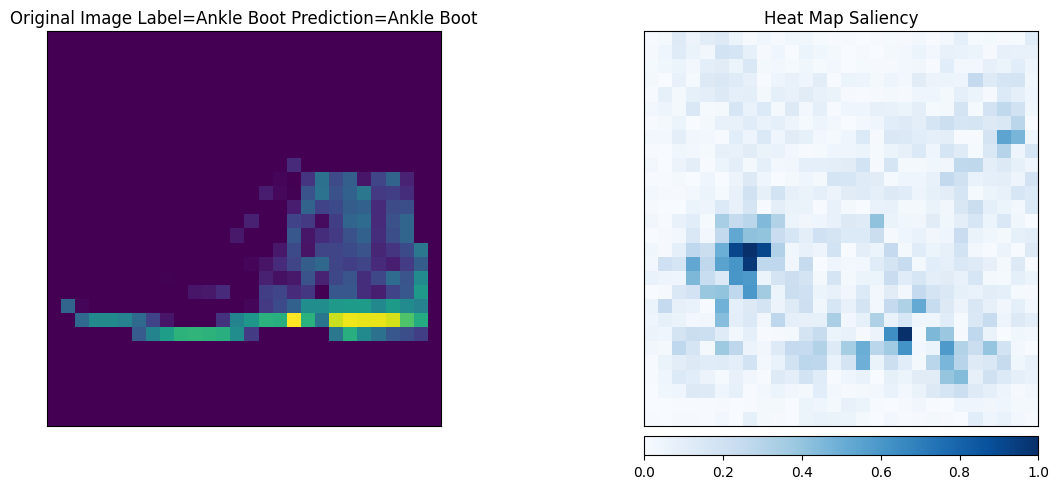

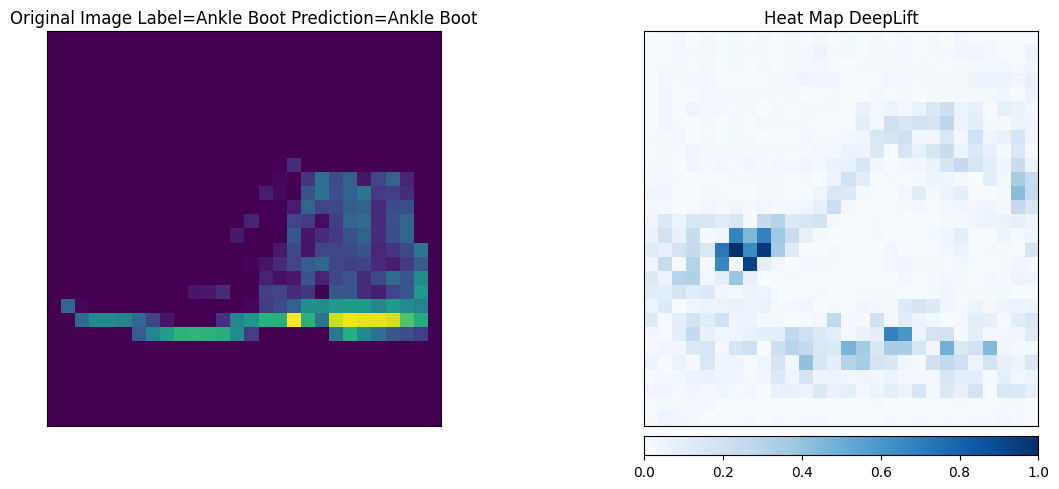

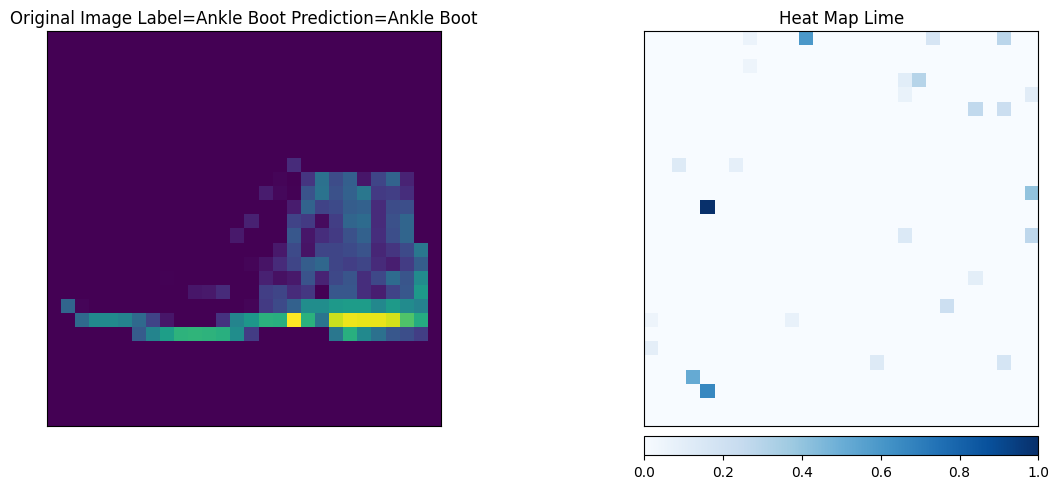

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


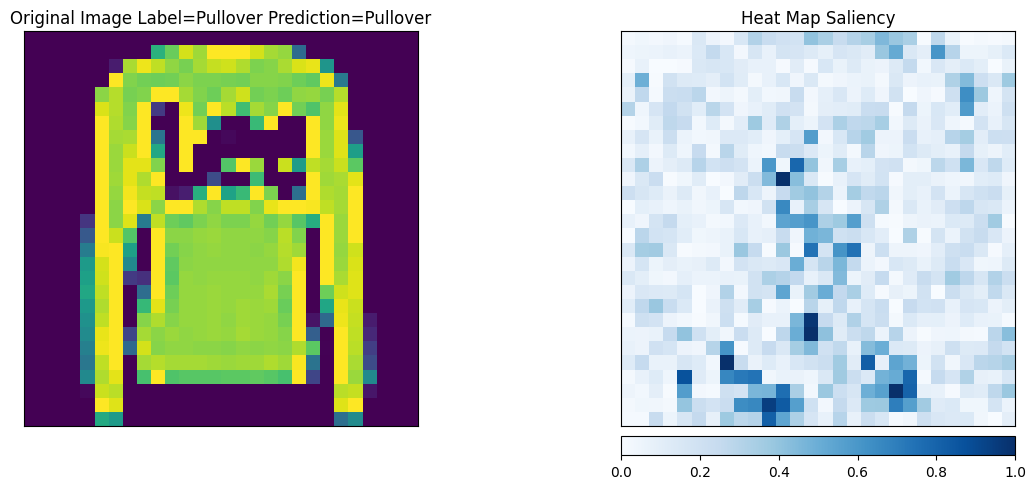

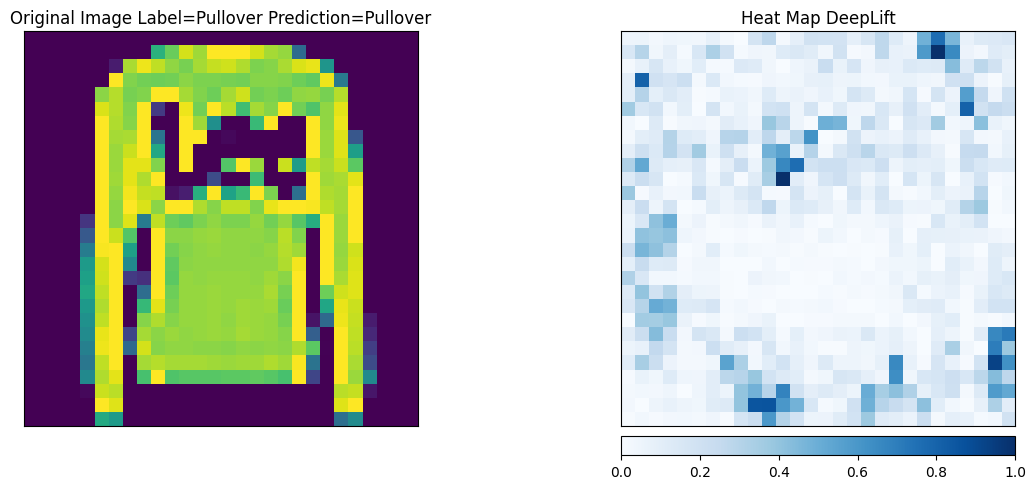

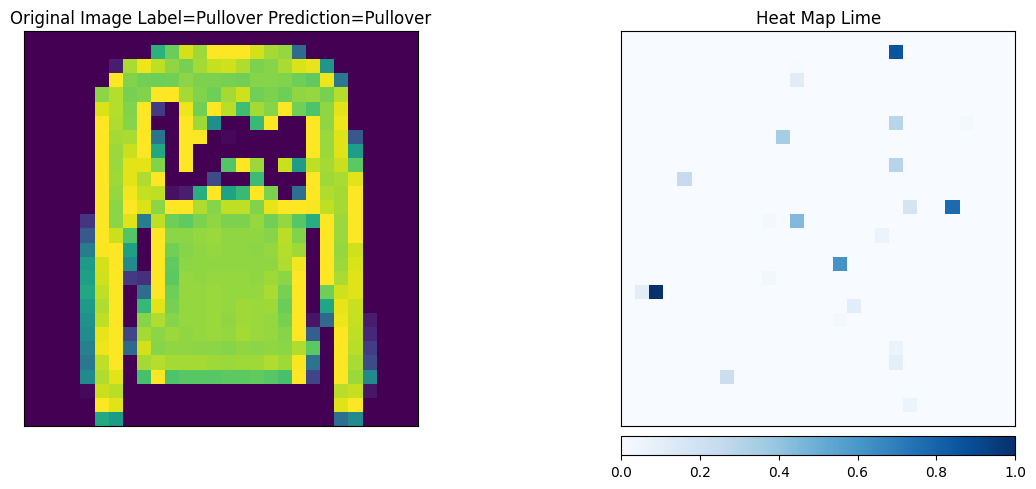

In [ ]:
visualize(examples)

 What happens if the examples are adversarially attacked (with
a local change of only small parts of the image)? Also try this out experimentally


In [ ]:
delta = [0, 0]

for i, (input, target) in enumerate(examples):
  # Create adversarial examples
  epsilon = 0.1
  delta[i] = torch.zeros_like(input, requires_grad=True)
  opt = torch.optim.Adam([delta[i]], lr=1e-1)

  for t in range(30):
      pred = model((input + delta[i]).unsqueeze(0))
      loss = -nn.CrossEntropyLoss()(pred, target.unsqueeze(0))
      if t % 5 == 0:
          print(t, loss.item())

      opt.zero_grad()
      loss.backward()
      opt.step()
      delta[i].data.clamp_(-epsilon, epsilon)

  print("True class probability:", nn.Softmax(dim=1)(pred)[0, target].item())


0 -2.7418097943154862e-06
5 -16.51287841796875
10 -18.152992248535156
15 -21.06912612915039
20 -22.984907150268555
25 -22.130489349365234
True class probability: 7.75568831379303e-10
0 -0.00023195437097456306
5 -4.273107528686523
10 -4.3763017654418945
15 -4.8026251792907715
20 -3.4818267822265625
25 -3.9111998081207275
True class probability: 0.007689420599490404


In [ ]:
adv_image1 = examples[0][0] + delta[0]
adv_image2 = examples[1][0] + delta[1]

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


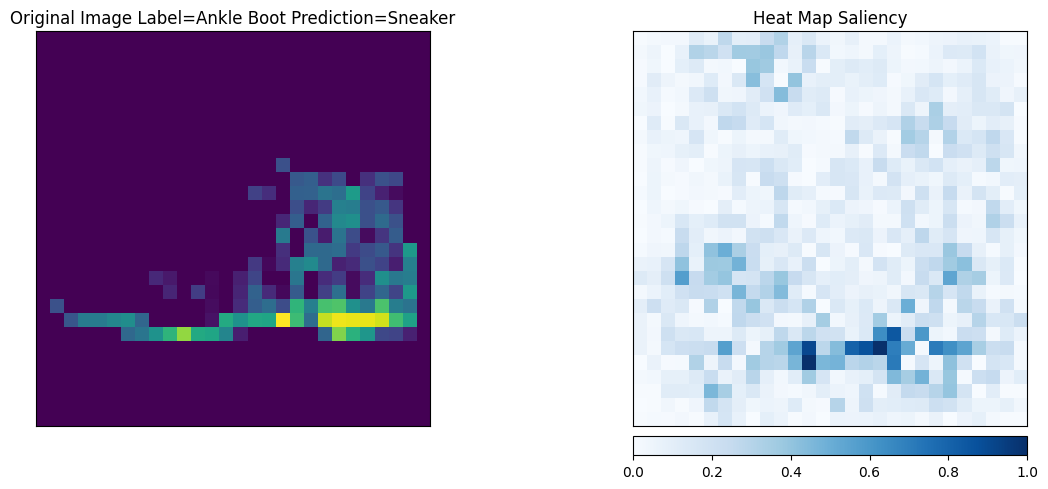

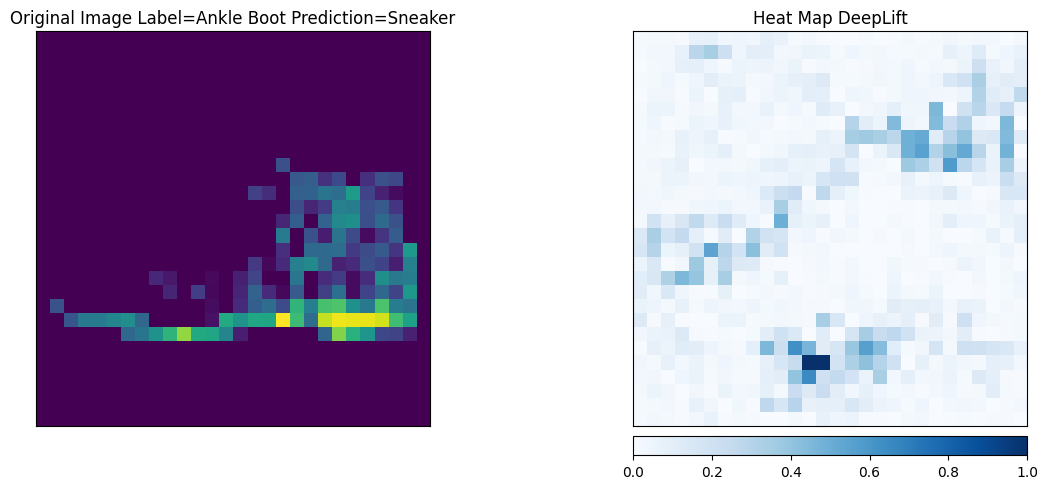

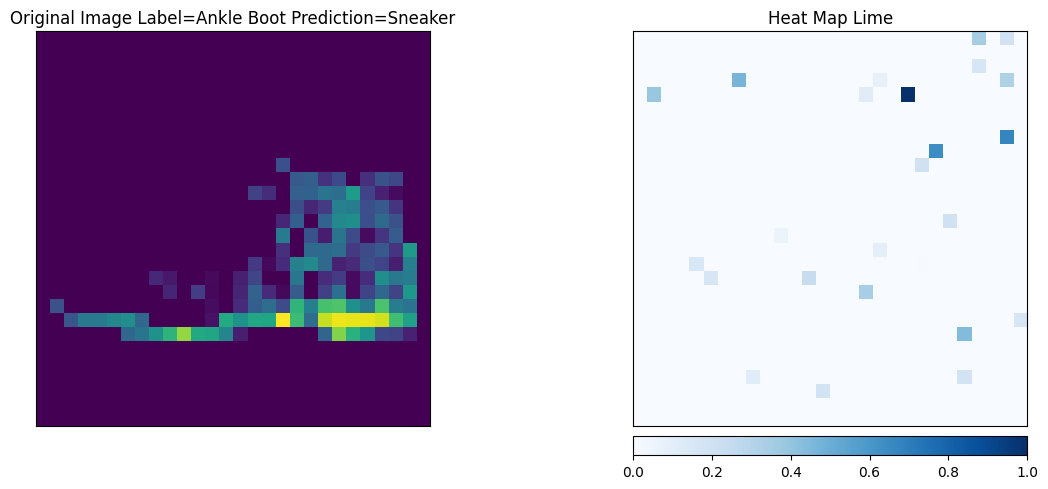

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


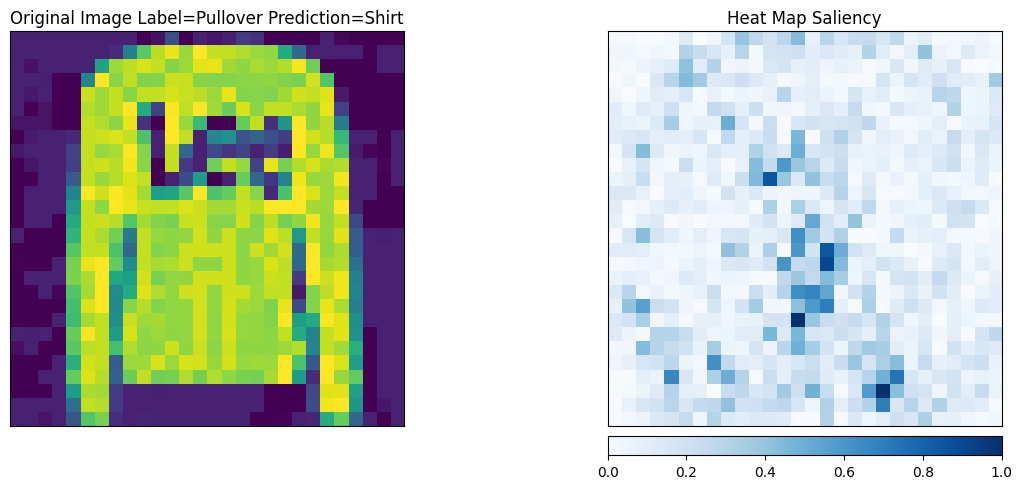

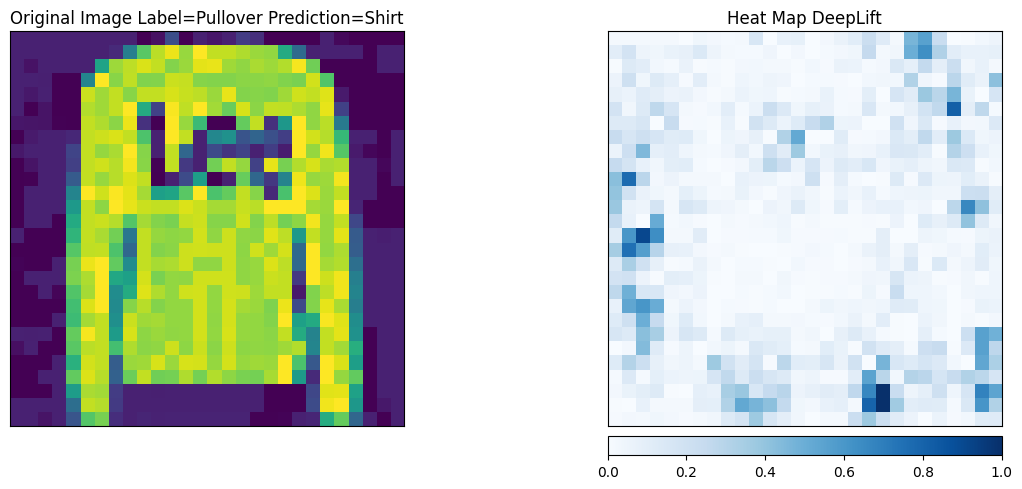

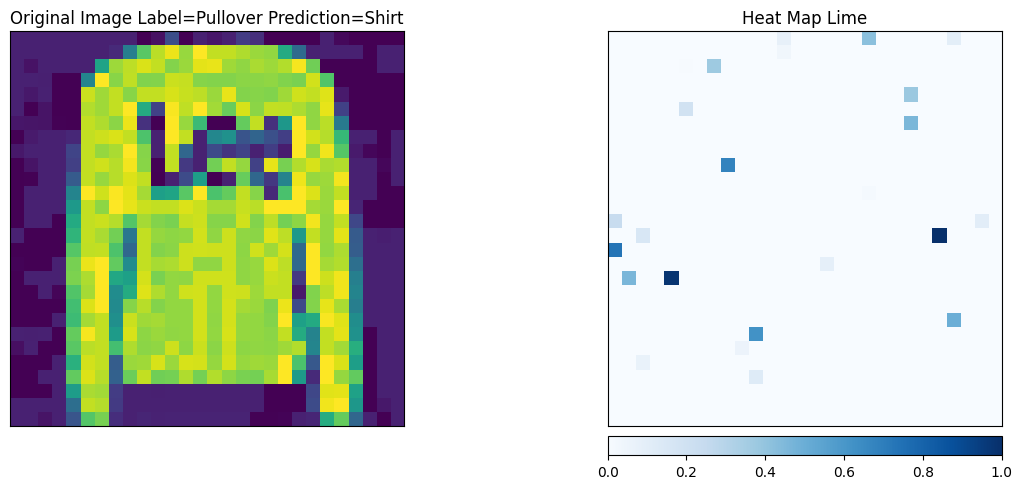

In [ ]:
visualize([(adv_image1, examples[0][1]), (adv_image2, examples[1][1])])